### Import libraries

In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import tslearn

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from tslearn.barycenters import euclidean_barycenter, dtw_barycenter_averaging, dtw_barycenter_averaging_subgradient,softdtw_barycenter
import random
import time
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster

from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option("display.max_columns", None)

In [439]:
# Create color class

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    

### Load data and data preparation

In [440]:
# Load data

aki = pd.read_excel("ThaiAKIepi_clean.xlsx")
aki_lao = pd.read_excel("Laos_SEAAKI_Cr.xls")
aki_indo = pd.read_excel("Indo_SEAAKI_Cr.xlsx")

In [441]:
aki.shape, aki_lao.shape,aki_indo.shape

((5375, 114), (1460, 35), (865, 884))

In [442]:
aki_lao = aki_lao.loc[(aki_lao["aki"] == 1) & (aki_lao["etiology_of_AKI"] == "Sepsis")]
aki_lao.shape

(109, 35)

<AxesSubplot:>

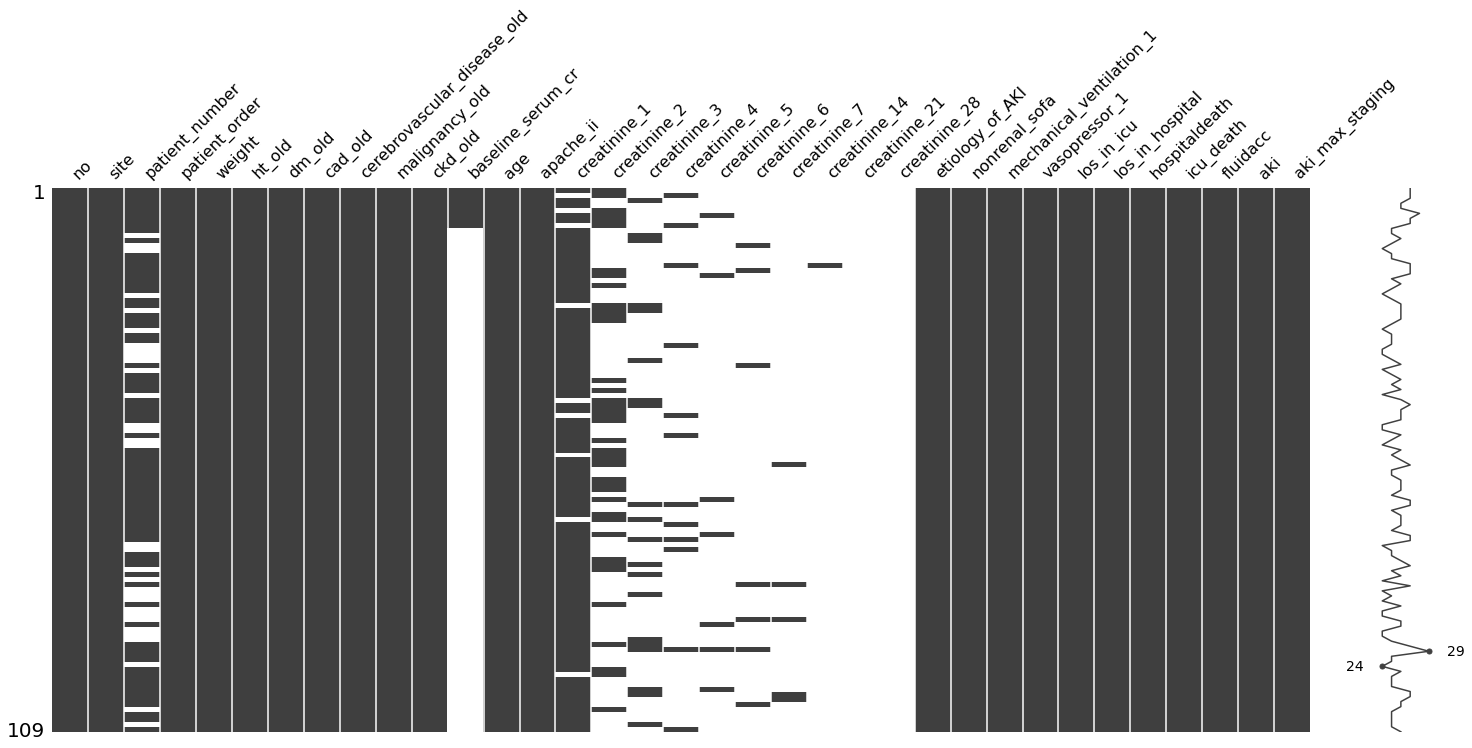

In [443]:
msno.matrix(aki_lao)

In [444]:
aki_lao.isnull().sum()/len(aki_lao)*100

no                               0.000000
site                             0.000000
patient_number                  29.357798
patient_order                    0.000000
weight                           0.000000
ht_old                           0.000000
dm_old                           0.000000
cad_old                          0.000000
cerebrovascular_disease_old      0.000000
malignancy_old                   0.000000
ckd_old                          0.000000
baseline_serum_cr               92.660550
age                              0.000000
apache_ii                        0.000000
creatinine_1                     8.256881
creatinine_2                    63.302752
creatinine_3                    81.651376
creatinine_4                    88.990826
creatinine_5                    93.577982
creatinine_6                    93.577982
creatinine_7                    95.412844
creatinine_14                   99.082569
creatinine_21                  100.000000
creatinine_28                  100

In [445]:
# use only row that have all cretinine info

aki_lao = aki_lao[aki_lao["baseline_serum_cr"].notna()]
aki_lao = aki_lao[aki_lao["creatinine_1"].notna()]
aki_lao = aki_lao[aki_lao["creatinine_2"].notna()]
aki_lao = aki_lao[aki_lao["creatinine_3"].notna()]
aki_lao = aki_lao[aki_lao["creatinine_4"].notna()]
aki_lao = aki_lao[aki_lao["creatinine_5"].notna()]

In [446]:
aki_lao.shape

(0, 35)

In [447]:
aki_indo = aki_indo.loc[(aki_indo["Max stage from Cr and Ur calculation and RRT"] != 0) & (aki_indo["cause_of_aki"] == "Sepsis")]

In [448]:
aki_indo.shape

(188, 884)

In [449]:
# use only row that have all cretinine info

aki_indo = aki_indo[aki_indo["crref_use"].notna()]
aki_indo = aki_indo[aki_indo["creatinine_1"].notna()]
aki_indo = aki_indo[aki_indo["creatinine_2"].notna()]
aki_indo = aki_indo[aki_indo["creatinine_3"].notna()]
aki_indo = aki_indo[aki_indo["creatinine_4"].notna()]
aki_indo = aki_indo[aki_indo["creatinine_5"].notna()]

In [450]:
aki_indo.shape

(44, 884)

In [451]:
aki_indo.head(3)

,site,patient_number,patient_order,recheck,birth_date,gender,weight,height,ideal_body_weight,time_of_icu_admission,reimbursement,diagnosis,ht_old,dm_old,cad_old,cerebrovascular_disease_old,malignancy_old,ckd_old,esrd,baseline_serum_creainine_by_mdrd,available_baseline,baseline_serum_cr,date_of_baseline_serum_cr,first_available_cr,first_available_cr_date,icu,glasgow_coma_score,temperature,mean_arterial,heart_rate,respiratory_rate,oxygenation,arterial_ph,serum_sodium,serum_potassium,serum_creatinine,hematocrit,white_blood_count,age,chronic_health_points,APACHE II,num_of_record_day,record_day_1,record_day_2,record_day_3,record_day_4,record_day_5,record_day_6,record_day_7,record_day_14,record_day_21,record_day_28,case_status_1,case_status_2,case_status_3,case_status_4,case_status_5,case_status_6,case_status_7,case_status_14,case_status_21,case_status_28,move_out_time_1,move_out_time_2,move_out_time_3,move_out_time_4,move_out_time_5,move_out_time_6,move_out_time_7,move_out_time_14,move_out_time_21,move_out_time_28,bun_1,bun_2,bun_3,bun_4,bun_5,bun_6,bun_7,bun_14,bun_21,bun_28,creatinine_1,creatinine_2,creatinine_3,creatinine_4,creatinine_5,creatinine_6,creatinine_7,creatinine_14,creatinine_21,creatinine_28,urine_output24hr_1,urine_output24hr_2,urine_output24hr_3,urine_output24hr_4,urine_output24hr_5,urine_output24hr_6,urine_output24hr_7,urine_output24hr_14,urine_output24hr_21,urine_output24hr_28,intake_1,intake_2,intake_3,intake_4,intake_5,intake_6,intake_7,intake_14,intake_21,intake_28,output_1,output_2,output_3,output_4,output_5,output_6,output_7,output_14,output_21,output_28,net_balance_1,net_balance_2,net_balance_3,net_balance_4,net_balance_5,net_balance_6,net_balance_7,net_balance_14,net_balance_21,net_balance_28,urine_output_cal_1,urine_output_cal_2,urine_output_cal_3,urine_output_cal_4,urine_output_cal_5,urine_output_cal_6,urine_output_cal_7,urine_output_cal_14,urine_output_cal_21,urine_output_cal_28,mechanical_ventilation_1_old,mechanical_ventilation_2,mechanical_ventilation_3,mechanical_ventilation_4,mechanical_ventilation_5,mechanical_ventilation_6,mechanical_ventilation_7,mechanical_ventilation_14,mechanical_ventilation_21,mechanical_ventilation_28,vasopressor_1_old,vasopressor_2,vasopressor_3,vasopressor_4,vasopressor_5,vasopressor_6,vasopressor_7,vasopressor_14,vasopressor_21,vasopressor_28,vasopressor_type_1,vasopressor_type_2,vasopressor_type_3,vasopressor_type_4,vasopressor_type_5,vasopressor_type_6,vasopressor_type_7,vasopressor_type_14,vasopressor_type_21,vasopressor_type_28,rate_of_vasopressor_1,rate_of_vasopressor_2,rate_of_vasopressor_3,rate_of_vasopressor_4,rate_of_vasopressor_5,rate_of_vasopressor_6,rate_of_vasopressor_7,rate_of_vasopressor_14,rate_of_vasopressor_21,rate_of_vasopressor_28,dose_of_vasopressor_1,dose_of_vasopressor_2,dose_of_vasopressor_3,dose_of_vasopressor_4,dose_of_vasopressor_5,dose_of_vasopressor_6,dose_of_vasopressor_7,dose_of_vasopressor_14,dose_of_vasopressor_21,dose_of_vasopressor_28,ml_of_vasopressor_1,ml_of_vasopressor_2,ml_of_vasopressor_3,ml_of_vasopressor_4,ml_of_vasopressor_5,ml_of_vasopressor_6,ml_of_vasopressor_7,ml_of_vasopressor_14,ml_of_vasopressor_21,ml_of_vasopressor_28,patient_weight_1,patient_weight_2,patient_weight_3,patient_weight_4,patient_weight_5,patient_weight_6,patient_weight_7,patient_weight_14,patient_weight_21,patient_weight_28,cal_dose_vasopressor_1,cal_dose_vasopressor_2,cal_dose_vasopressor_3,cal_dose_vasopressor_4,cal_dose_vasopressor_5,cal_dose_vasopressor_6,cal_dose_vasopressor_7,cal_dose_vasopressor_14,cal_dose_vasopressor_21,cal_dose_vasopressor_28,rs_1,rs_2,rs_3,rs_4,rs_5,rs_6,rs_7,rs_14,rs_21,rs_28,coagulation_1,coagulation_2,coagulation_3,coagulation_4,coagulation_5,coagulation_6,coagulation_7,coagulation_14,coagulation_21,coagulation_28,cns_1,cns_2,cns_3,cns_4,cns_5,cns_6,cns_7,cns_14,cns_21,cns_28,liver_1,liver_2,liver_3,liver_4,liver_5,liver_6,liver_7,liver_14,liver_21,liver_28,renal_1,renal_2,renal_3,renal_4,renal_5,renal_6,renal_7,renal_14,renal

In [452]:
aki_indo["primary diagnosis"].value_counts()

Respiratory Diseases         13
Infectious Diseases           8
Cardiovascular Diseases       6
Neurologic Diseases           5
Renal Diseases                4
Endocrine Diseases            3
Surgical Related Disease      3
Gastrointestinal Diseases     1
Name: primary diagnosis, dtype: int64

In [453]:
# Create dx function

def dx(x):
    if x["primary diagnosis"] == "Respiratory Diseases":
        x["respidis"] += 1
    if x["primary diagnosis"] == "Infectious Diseases":
        x["infectdis"] += 1
    if x["primary diagnosis"] == "Cardiovasculr Diseases":
        x["cardiodis"] += 1
    if x["primary diagnosis"] == "Neurologic Diseases":
        x["neurodis"] += 1
    if x["primary diagnosis"] == "Renal Diseases":
        x["renaldis"] +=1
    if x["primary diagnosis"] == "Endocrine Diseases":
        x["endocrinedis"] += 1
    if x["primary diagnosis"] == "Surgical Related Disease":
        x["surgdis"] += 1
    if x["primary diagnosis"] == "Gastrointestinal Diseases":
        x["gastrodis"] += 1
    
    return x

aki_indo["respidis"] = 0
aki_indo["infectdis"] = 0
aki_indo["cardiodis"] = 0
aki_indo["neurodis"] = 0
aki_indo["renaldis"] = 0
aki_indo["endocrinedis"] = 0
aki_indo["surgdis"] = 0
aki_indo["gastrodis"] = 0
aki_indo["hematodis"] = 0
aki_indo["rheumdis"] = 0
aki_indo["oncoldis"] = 0

aki_indo = aki_indo.apply(dx, axis=1)
    

In [454]:
# Create MV function

def mv(x):
    if x["mechanical_ventilation_1_old"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_2"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_3"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_4"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_5"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_6"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_7"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_14"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_21"] == "Yes":
        x["mechvent_n"] = 1
    if x["mechanical_ventilation_28"] == "Yes":
        x["mechvent_n"] = 1
    
    return x
        
aki_indo["mechvent_n"] = 0
aki_indo = aki_indo.apply(mv, axis=1)

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [455]:
# Create Vasopressor function

def vsp(x):
    if x["vasopressor_1_old"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_2"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_3"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_4"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_5"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_6"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_7"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_14"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_21"] == 1:
        x["vaso_n"] = 1
    if x["vasopressor_28"] == 1:
        x["vaso_n"] = 1
    
    return x
        
aki_indo["vaso_n"] = 0
aki_indo = aki_indo.apply(vsp, axis=1)

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [456]:
# Create rrt function

def rrt(x):
    if pd.notna(x["mode_of_rrt_1"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_2"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_3"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_4"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_5"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_6"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_7"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_14"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_21"]):
        x["rrt_any"] = 1
    if pd.notna(x["mode_of_rrt_28"]):
        x["rrt_any"] = 1
    return x

aki_indo["rrt_any"] = 0
aki_indo = aki_indo.apply(rrt, axis=1)

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [457]:
columns = ["gender","weight","age","ht_old","dm_old","cad_old","cerebrovascular_disease_old","malignancy_old","ckd_old","respidis","infectdis","cardiodis",
           "neurodis","renaldis","endocrinedis","surgdis","gastrodis","hematodis","rheumdis","oncoldis","APACHE II","los_in_hospital","hospitaldeath","icu_death","los_in_icu",
           "mechvent_n","vaso_n", "sofa_1", "rrt_any","Max stage from Cr and Ur calculation and RRT","percentfluid_1","recovery","time2aki","crref_use",
           "creatinine_1","creatinine_2","creatinine_3","creatinine_4","creatinine_5"]
          

In [458]:
aki_indo = aki_indo[columns]

In [459]:
aki_indo = aki_indo.rename(columns={"gender":"sexfac_n","ht_old":"ht_n","dm_old":"dm_n","cad_old":"cad_n","cerebrovascular_disease_old":"cvd",
                                   "malignancy_old":"malignancy_n","ckd_old":"ckd_n","APACHE II":"apache_ii","los_in_hospital":"hoslos_n",
                                   "hospitaldeath":"hospital_discharge_status_n","icu_death":"icu_discharge_status_n","los_in_icu":"icu_los_n",
                                   "sofa_1":"sofa_nonrenal_n","recovery":"recovery_n","Max stage from Cr and Ur calculation and RRT":"maxakinom","time2aki":"time2aki_n"})

In [460]:
aki_indo.shape

(44, 39)

In [461]:
aki_indo.head()

,sexfac_n,weight,age,ht_n,dm_n,cad_n,cvd,malignancy_n,ckd_n,respidis,infectdis,cardiodis,neurodis,renaldis,endocrinedis,surgdis,gastrodis,hematodis,rheumdis,oncoldis,apache_ii,hoslos_n,hospital_discharge_status_n,icu_discharge_status_n,icu_los_n,mechvent_n,vaso_n,sofa_nonrenal_n,rrt_any,maxakinom,percentfluid_1,recovery_n,time2aki_n,crref_use,creatinine_1,creatinine_2,creatinine_3,creatinine_4,creatinine_5
4,Female,86,69,No,Yes,No,No,No,No,0,0,0,1,0,0,0,0,0,0,0,19,20.0,1.0,1,19.0,1,0,9,1,3,3.488372,0,14.0,0.80,6.1,4.9,3.4,3.8,4.3
10,Male,70,70,No,Yes,No,No,No,No,0,0,0,0,0,1,0,0,0,0,0,31,16.0,1.0,1,16.0,1,1,7,1,3,29.828571,0,14.0,2.60,3.1,3.9,4.0,4.3,4.4
15,Male,70,59,Yes,No,No,No,No,Yes,1,0,0,0,0,0,0,0,0,0,0,20,8.0,1.0,1,8.0,1,1,8,1,3,-6.771429,1,NaN,11.20,9.2,9.3,5.6,7.6,9.8
16,Male,102,56,No,Yes,No,No,No,No,1,0,0,0,0,0,0,0,0,0,0,15,39.0,0.0,0,16.0,1,1,6,1,3,-1.882353,0,14.0,1.13,3.3,3.4,4.0,4.2,3.9
18,Female,50,84,Yes,Yes,No,No,No,No,0,0,0,0,0,1,0,0,0,0,0,24,NaN,1.0,1,NaN,1,1,7,1,3,9.040000,0,14.0,2.00,3.5,3.7,4.5,3.8,2.9


In [462]:
# Select only AKI + sepsis patients

aki = aki.loc[(aki["akiny"] == 1) & (aki["akicause_revised_n"] == "Sepsis") ]
aki.shape

(1162, 114)

In [463]:
# use only row that have all cretinine info

aki = aki[aki["crref_use"].notna()]
aki = aki[aki["creatinine_1"].notna()]
aki = aki[aki["creatinine_2"].notna()]
aki = aki[aki["creatinine_3"].notna()]
aki = aki[aki["creatinine_4"].notna()]
aki = aki[aki["creatinine_5"].notna()]

In [464]:
# Interested columns

columns = ["age","sexfac_n","weight","cardiodis","renaldis","infectdis","gastrodis","hematodis","neurodis","rheumdis","oncoldis","surgdis","ht_n","dm_n","ckd_n","cad_n","cvd","malignancy_n","apache_ii","sofa_nonrenal_n","percentfluid_1",
          "vaso_n","mechvent_n","maxakinom","time2aki_n","rrt_any","hoslos_n","hospital_discharge_status_n","icu_los_n","icu_discharge_status_n","recovery_n","crref_use","creatinine_1","creatinine_2","creatinine_3","creatinine_4","creatinine_5"]

In [465]:
aki_select = aki[columns]
print(f"AKI Sepsis number of rows : {aki_select.shape[0]} | columns : {aki_select.shape[1]}")
aki_select.head(5)

AKI Sepsis number of rows : 173 | columns : 37


,age,sexfac_n,weight,cardiodis,renaldis,infectdis,gastrodis,hematodis,neurodis,rheumdis,oncoldis,surgdis,ht_n,dm_n,ckd_n,cad_n,cvd,malignancy_n,apache_ii,sofa_nonrenal_n,percentfluid_1,vaso_n,mechvent_n,maxakinom,time2aki_n,rrt_any,hoslos_n,hospital_discharge_status_n,icu_los_n,icu_discharge_status_n,recovery_n,crref_use,creatinine_1,creatinine_2,creatinine_3,creatinine_4,creatinine_5
8,63.0,Male,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Yes,No,No,0.0,0.0,22.0,11.0,0.985714,0.0,Yes,3.0,1.0,1.0,19.0,0.0,4.0,0.0,1.0,3.3,0.87,0.95,0.89,0.9,1.47
51,75.0,Female,68.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,No,No,No,0.0,0.0,25.0,7.0,-0.941176,0.0,Yes,3.0,1.0,1.0,18.0,1.0,17.0,1.0,0.0,2.2,4.60,4.97,5.48,4.97,5.7
85,78.0,Female,55.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes,Yes,No,No,0.0,0.0,32.0,12.0,-0.781818,1.0,Yes,3.0,1.0,1.0,24.0,0.0,7.0,0.0,0.0,0.8,2.22,2.73,2.37,2.07,1.58
118,68.0,Female,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Yes,No,No,0.0,0.0,22.0,6.0,0.615385,0.0,Yes,3.0,1.0,0.0,13.0,1.0,7.0,1.0,0.0,0.8,3.10,3.10,3.10,3,3.1
143,78.0,Male,58.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No,No,No,No,0.0,0.0,29.0,11.0,-1.224138,1.0,Yes,3.0,1.0,1.0,47.0,1.0,2.0,1.0,0.0,1.8,0.96,3.25,4.02,5.37,6.8


In [466]:
# add extra 2 columns from AKI indo
aki_select["respidis"] = 0
aki_select["endocrinedis"] = 0

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [467]:
# Merge aki and aki_indo
aki_select = pd.concat([aki_select, aki_indo])

In [468]:
aki_select["creatinine_4"] = aki_select["creatinine_4"].astype(float)
aki_select["creatinine_5"] = aki_select["creatinine_5"].astype(float)

In [469]:
print(color.BOLD + "Overall stats in AKI sepsis" + color.END)
aki_select.describe()

Overall stats in AKI sepsis


,age,weight,cardiodis,renaldis,infectdis,gastrodis,hematodis,neurodis,rheumdis,oncoldis,surgdis,apache_ii,sofa_nonrenal_n,percentfluid_1,vaso_n,maxakinom,time2aki_n,rrt_any,hoslos_n,hospital_discharge_status_n,icu_los_n,icu_discharge_status_n,recovery_n,crref_use,creatinine_1,creatinine_2,creatinine_3,creatinine_4,creatinine_5,respidis,endocrinedis
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,212.000000,216.000000,217.000000,216.000000,217.000000,215.000000,217.000000,216.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,66.230415,61.092166,0.377880,0.156682,0.751152,0.082949,0.032258,0.046083,0.018433,0.004608,0.036866,21.912442,7.797235,2.114614,0.638889,2.576037,2.495370,0.262673,19.348837,0.589862,9.541667,0.419355,0.165899,1.707097,2.832903,2.899078,2.882627,2.791106,2.678018,0.059908,0.013825
std,16.173320,14.092314,0.485979,0.364341,0.433345,0.276443,0.177093,0.210150,0.134823,0.067884,0.188869,6.516836,3.644553,4.563823,0.481438,0.697201,3.447949,0.441104,21.843842,0.492996,9.743125,0.494594,0.372850,2.248600,2.918326,2.703804,2.655589,2.614379,2.397484,0.237865,0.117034
min,16.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,-12.300000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.400000,0.400000,0.340000,0.290000,0.200000,0.300000,0.000000,0.000000
25%,57.000000,50.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,5.000000,-0.450000,0.000000,2.000000,1.000000,0.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.800000,1.000000,1.100000,1.100000,0.990000,1.000000,0.000000,0.000000
50%,68.000000,60.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,8.000000,1.457222,1.000000,3.000000,1.000000,0.000000,13.000000,1.000000,6.000000,0.000000,0.000000,1.040000,1.750000,2.000000,2.000000,1.860000,1.890000,0.000000,0.000000
75%,78.000000,70.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,10.000000,3.498951,1.000000,3.000000,1.000000,1.000000,26.000000,1.000000,12.000000,1.000000,0.000000,1.220000,3.400000,3.700000,4.000000,3.900000,3.700000,0.000000,0.000000
max,93.000000,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,42.000000,19.000000,29.828571,1.000000,3.000000,21.000000,1.000000,167.000000,1.000000,73.000000,1.000000,1.000000,17.750000,25.080000,20.690000,20.770000,20.230000,16.180000,1.000000,1.000000


In [470]:
# ROC of creatinine from baseline

aki_5days_complete = aki_select

aki_5days_complete.rename(columns={"crref_use":"baseline"},inplace=True)

aki_5days_complete["ROC_1"] = (aki_5days_complete["creatinine_1"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100
aki_5days_complete["ROC_2"] = (aki_5days_complete["creatinine_2"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100
aki_5days_complete["ROC_3"] = (aki_5days_complete["creatinine_3"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100
aki_5days_complete["ROC_4"] = (aki_5days_complete["creatinine_4"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100
aki_5days_complete["ROC_5"] = (aki_5days_complete["creatinine_5"] - aki_5days_complete["baseline"])/aki_5days_complete["baseline"] * 100


In [471]:
# Create function to encode data

def convert(x):
    if x["ht_n"] == "Yes":
        x["ht_n"] = 1
    else:
        x["ht_n"] = 0
        
    if x["dm_n"] == "Yes":
        x["dm_n"] = 1
    else:
        x["dm_n"] = 0
        
    if x["ckd_n"] == "Yes":
        x["ckd_n"] = 1
    else:
        x["ckd_n"] = 0
        
    if x["cad_n"] == "Yes":
        x["cad_n"] = 1
    else:
        x["cad_n"] = 0
    
    if (x["cvd"] == "Yes") | (x["cvd"] == 1):
        x["cvd"] = 1
    else:
        x["cvd"] = 0
    
    if (x["malignancy_n"] == "Yes") | (x["malignancy_n"] == 1):
        x["malignancy_n"] =1
    else:
        x["malignancy_n"] = 0
        
    if x["mechvent_n"] == "Yes":
        x["mechvent_n"] = 1
    else:
        x["mechvent_n"] = 0
    
    if x["sexfac_n"] == "Female":
        x["sexfac_n"] = 1
    else:
        x["sexfac_n"] = 0
    
    return x
    

In [472]:
aki_5days_complete = aki_5days_complete.apply(convert, axis=1)

In [473]:
# Check data types of each columns

aki_5days_complete.dtypes

age                            float64
sexfac_n                         int64
weight                         float64
cardiodis                      float64
renaldis                       float64
infectdis                      float64
gastrodis                      float64
hematodis                      float64
neurodis                       float64
rheumdis                       float64
oncoldis                       float64
surgdis                        float64
ht_n                             int64
dm_n                             int64
ckd_n                            int64
cad_n                            int64
cvd                              int64
malignancy_n                     int64
apache_ii                      float64
sofa_nonrenal_n                float64
percentfluid_1                 float64
vaso_n                         float64
mechvent_n                       int64
maxakinom                      float64
time2aki_n                     float64
rrt_any                  

In [474]:
columns = ["ROC_1", "ROC_2", "ROC_3", "ROC_4", "ROC_5"]
aki_5days_complete = aki_5days_complete[columns]

In [475]:
# Scaling data with standard scaler

scaler = StandardScaler()
scaler.fit(aki_5days_complete)
aki_5days_complete_scale = scaler.transform(aki_5days_complete)
aki_5days_complete_scale[:5]

array([[-0.76245017, -0.7964387 , -0.80795695, -0.78152822, -0.79929343],
       [-0.15215215, -0.12000942, -0.02708936, -0.09162147,  0.08650011],
       [ 0.07633008,  0.2757875 ,  0.13869853,  0.02244207, -0.16779019],
       [ 0.44372342,  0.43449622,  0.4594881 ,  0.42620328,  0.61666257],
       [-0.67237301, -0.27564185, -0.11764014,  0.15992353,  0.57652251]])

In [476]:
# Calculate distance between time series
ds_scale = dtw.distance_matrix(aki_5days_complete_scale)

### Hierachical clustering and heatmap with dendrogram

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


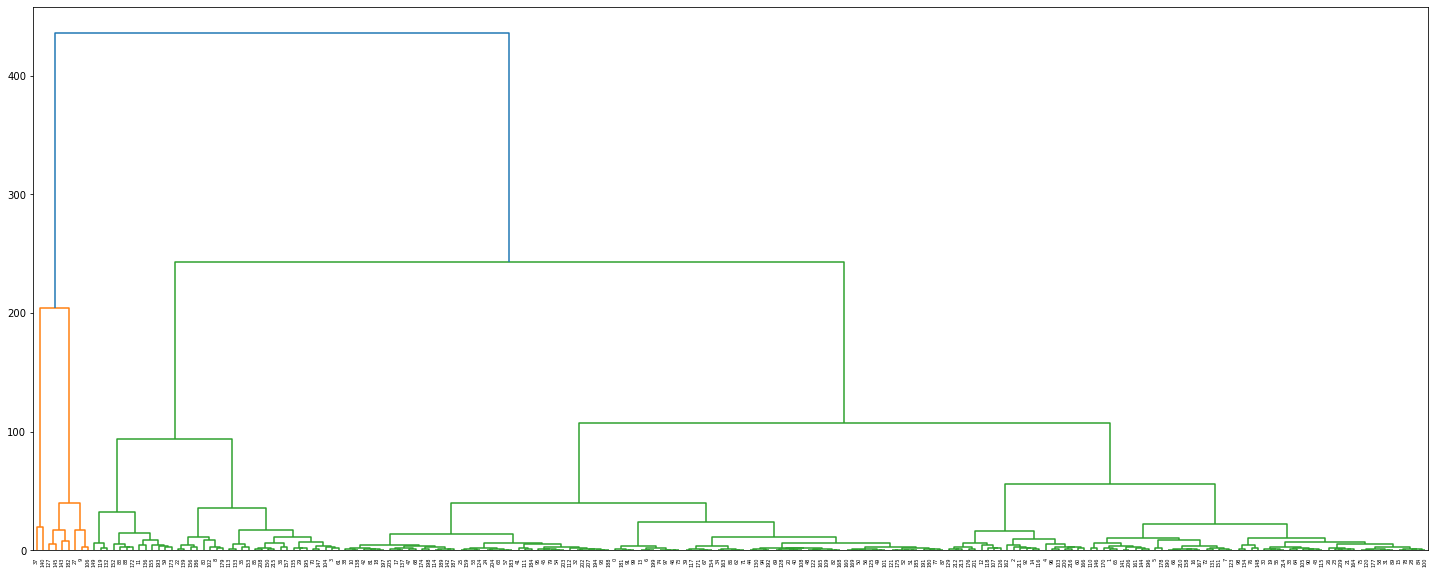

In [477]:
z_scale = linkage(ds_scale, "ward")
fig = plt.figure(figsize=(25,10))
dn = dendrogram(z_scale)

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


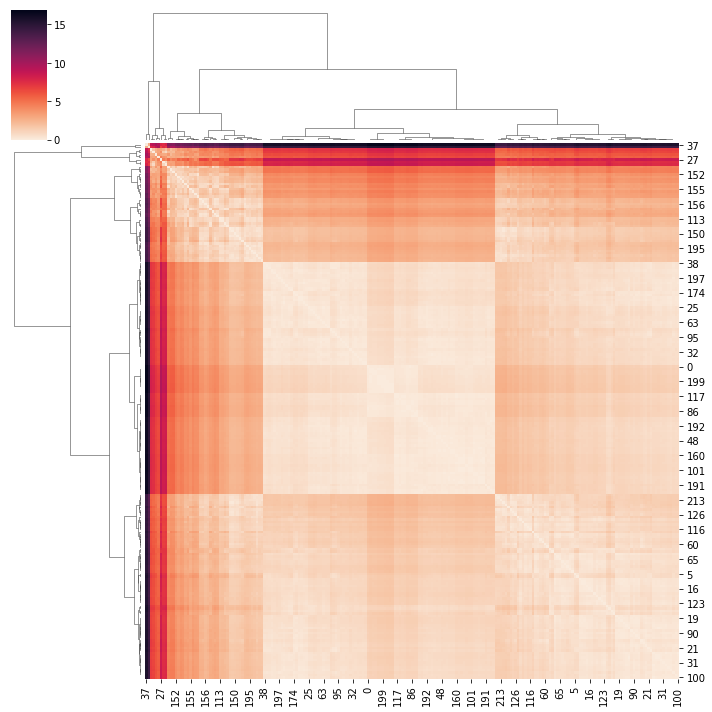

In [478]:
g_scale = sns.clustermap(ds_scale, method="ward", cmap="rocket_r")

### Dimension reduction with PCA

[4.68490949 0.16344391]


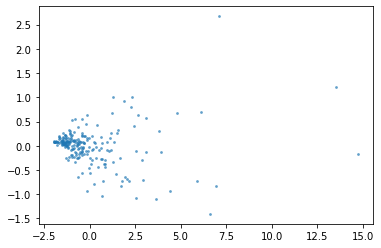

In [479]:
from sklearn.decomposition import PCA
#PCA with two principal components
PCA_2d = PCA(n_components=2).fit(aki_5days_complete_scale)
#PCA_2d.head()
print(PCA_2d.explained_variance_)
PCA_2d = PCA(n_components=2).fit_transform(aki_5days_complete_scale)
plt.scatter(PCA_2d[:, 0], PCA_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k');

### Silhouette Analysis

Silhouette score of 2 clusters : 0.7895715005587753
Silhouette score of 3 clusters : 0.6030980021512411
Silhouette score of 4 clusters : 0.6104406457269609
Silhouette score of 5 clusters : 0.44214540116531276
Silhouette score of 6 clusters : 0.43004359934655
Silhouette score of 7 clusters : 0.3818000798551484


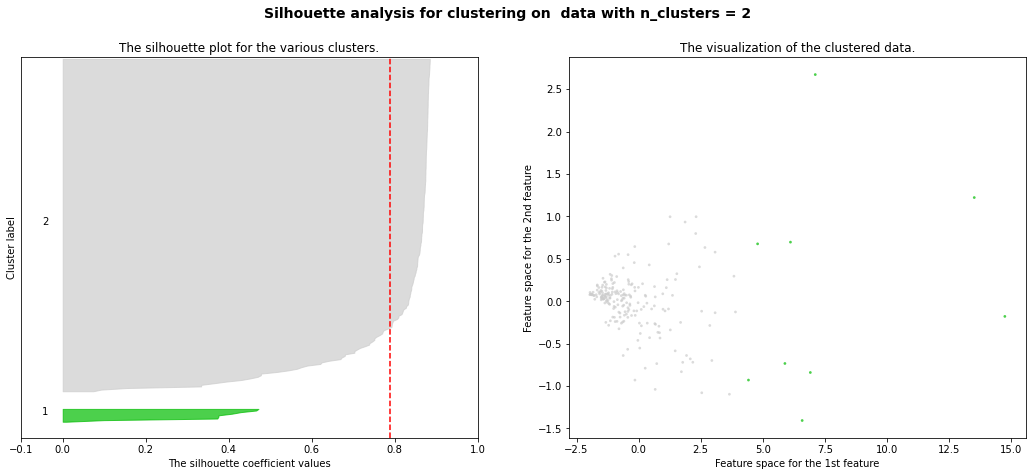

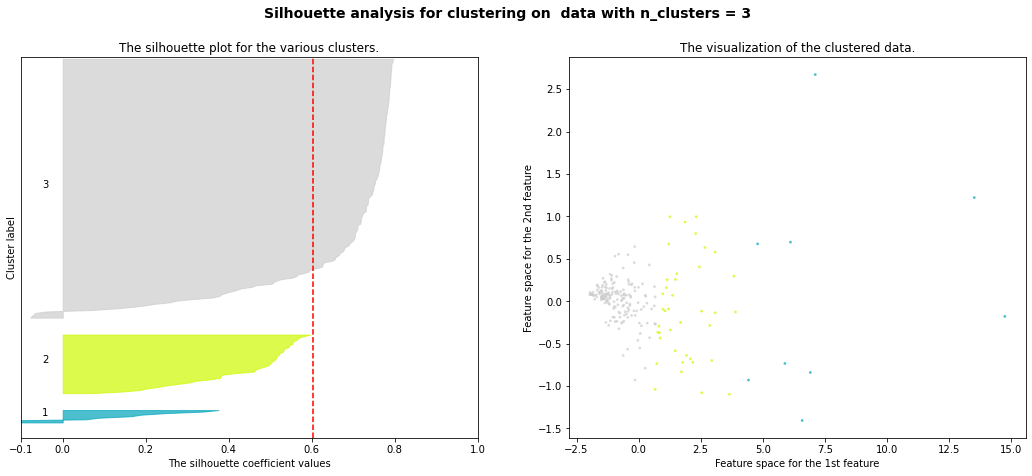

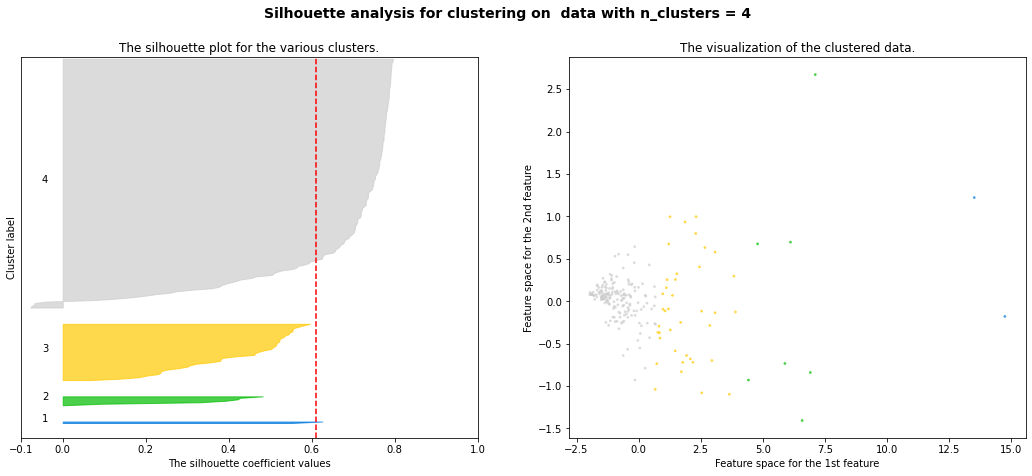

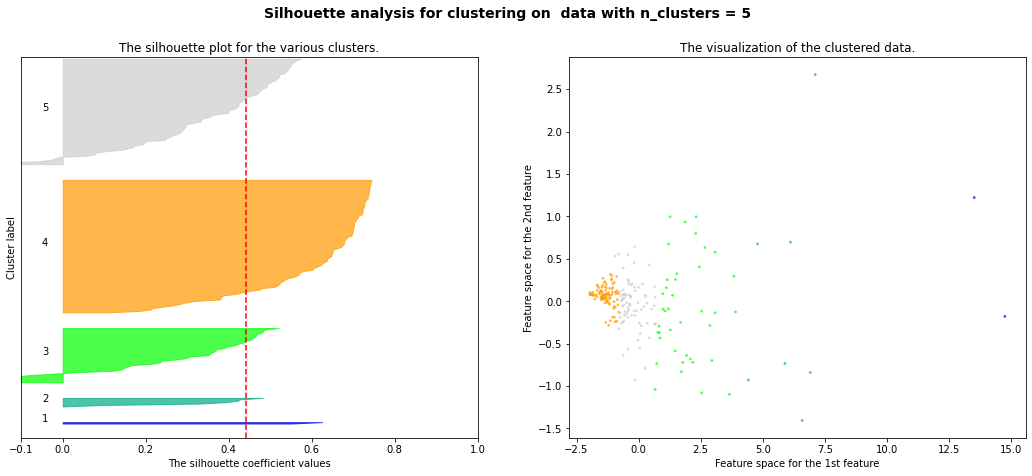

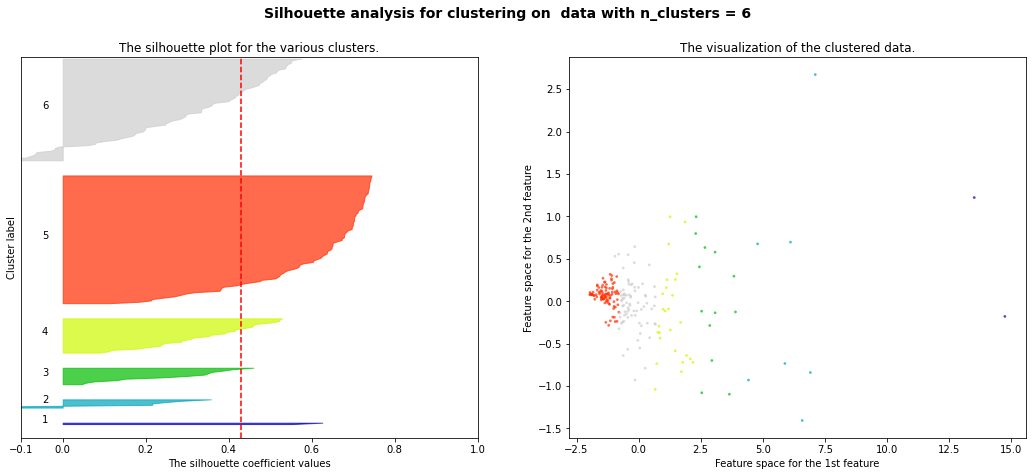

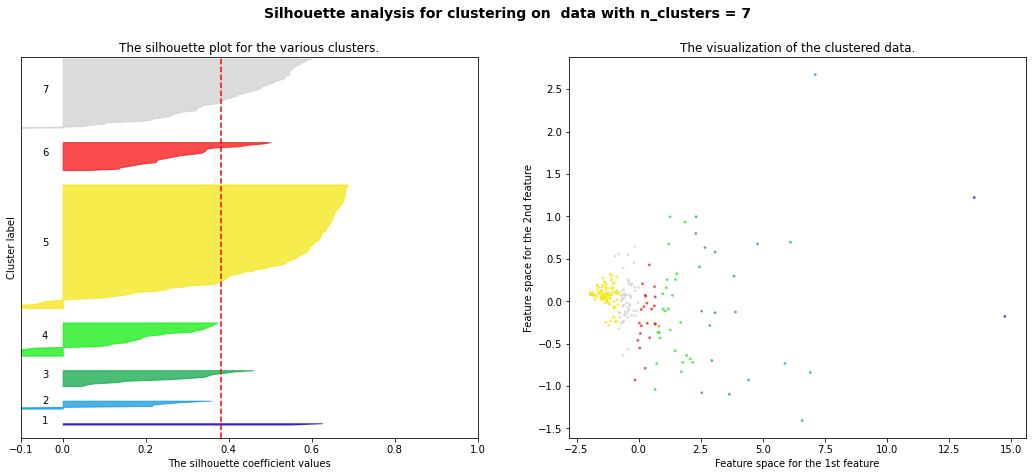

In [480]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm


threshold_level = {2:300, 3:230, 4:150, 5:100, 6:80, 7:50}

for n_clusters in range(2,8):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,7)
    
     # The 1st subplot is the silhoueete plot (range -1,1)
    ax1.set_xlim([-0.1, 1])
     # The (n_cluster+1) *10 is for inserting blank space between silhouette
    ax1.set_ylim([0, aki_5days_complete.shape[0] + (n_clusters*10)])
    
    cluster_scale = fcluster(z_scale, t=threshold_level[n_clusters], criterion="distance")
    silhouette_avg =  silhouette_score(aki_5days_complete_scale, cluster_scale)
    print(f"Silhouette score of {n_clusters} clusters : {silhouette_avg}")
    
    y_lower = 10
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(aki_5days_complete_scale, cluster_scale)
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_scale == i+1]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i+1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_scale.astype(float)) / n_clusters)
    ax2.scatter(PCA_2d[:, 0], PCA_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

   

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for clustering on  data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Threshold at 150 --> 4 clusters

In [481]:
# label each patient with threshold=150
cluster_scale_2 = fcluster(z_scale, t=150, criterion="distance")

In [482]:
# Check number of each clusters
unique_scale_2, counts_scale_2 = np.unique(cluster_scale_2, return_counts=True)
dict(zip(unique_scale_2, counts_scale_2))

{1: 2, 2: 7, 3: 39, 4: 169}

In [483]:
# Concat label back to creatinine array
aki_5days_scale_label_2 = np.column_stack((aki_5days_complete_scale, cluster_scale_2))

In [484]:
columns_value = ["ROC_1", "ROC_2", "ROC_3", "ROC_4", "ROC_5", "label"]
df_scale_2 = pd.DataFrame(aki_5days_scale_label_2, columns=columns_value)

In [485]:
def plot_helper(barycenter):
    # plot all points of the data set
    for series in q:
        series = np.append([0], series)
        plt.plot(series.ravel(), "k-", alpha=.2)
    # plot the given barycenter of them
    #plt.plot(barycenter.ravel(), "r-", linewidth=2)
    b = dtw_barycenter_averaging_subgradient(q, max_iter=100, tol=1e-3)
    ar1 = []
    ar2 = []
    for i,j in enumerate(b):
        x = ar1.append(i)
        y = ar2.append(j[0])
    plt.plot(range(1, 1+len(ar2)),ar2, c="r")
    

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)


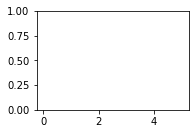

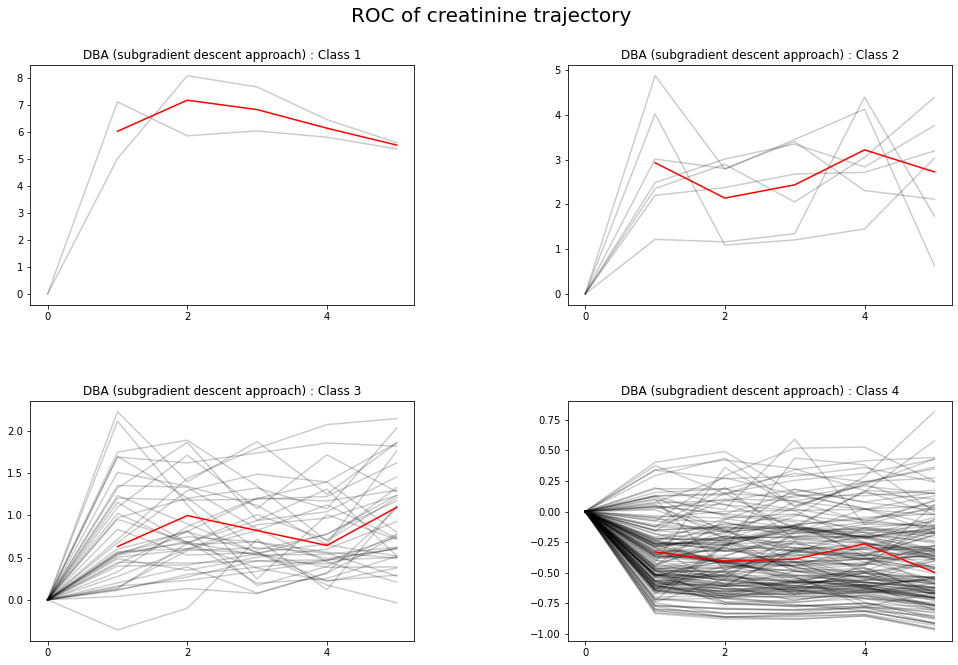

In [486]:
ax2 = plt.subplot(2, 2, 1)
plt.figure(figsize=(16,10))

for i in range(4):
    sam = df_scale_2.loc[df_scale_2["label"] == i+1].transpose()
    sam.drop(index="label", inplace=True)
    q = sam.transpose().to_numpy()
    length_of_sequence = q.shape[1]
    plt.subplot(2, 2, i+1, sharex=ax2)
    plt.title(f"DBA (subgradient descent approach) : Class {i+1}")
    plot_helper(dtw_barycenter_averaging_subgradient(q, max_iter=100, tol=1e-3))

plt.suptitle("ROC of creatinine trajectory", fontsize=20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [487]:
aki_select.reset_index(inplace=True, drop=True)

In [488]:
df_2 = pd.concat([df_scale_2,aki_select], axis=1)

In [489]:
columns = ["age","sexfac_n","weight","cardiodis","renaldis","infectdis","gastrodis","hematodis","neurodis","rheumdis","oncoldis","surgdis","ht_n","dm_n","ckd_n","cad_n","cvd","malignancy_n","apache_ii","sofa_nonrenal_n","percentfluid_1",
          "vaso_n","mechvent_n","maxakinom","time2aki_n","rrt_any","hoslos_n","hospital_discharge_status_n","icu_los_n","icu_discharge_status_n","recovery_n","baseline","label"]

In [490]:
df_2 = df_2[columns]
df_2 = df_2.apply(convert, axis=1)

In [491]:
df_2

,age,sexfac_n,weight,cardiodis,renaldis,infectdis,gastrodis,hematodis,neurodis,rheumdis,oncoldis,surgdis,ht_n,dm_n,ckd_n,cad_n,cvd,malignancy_n,apache_ii,sofa_nonrenal_n,percentfluid_1,vaso_n,mechvent_n,maxakinom,time2aki_n,rrt_any,hoslos_n,hospital_discharge_status_n,icu_los_n,icu_discharge_status_n,recovery_n,baseline,label
0,63.0,0,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,22.0,11.0,0.985714,0.0,1,3.0,1.0,1.0,19.0,0.0,4.0,0.0,1.0,3.30,4.0
1,75.0,1,68.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,25.0,7.0,-0.941176,0.0,1,3.0,1.0,1.0,18.0,1.0,17.0,1.0,0.0,2.20,4.0
2,78.0,1,55.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,32.0,12.0,-0.781818,1.0,1,3.0,1.0,1.0,24.0,0.0,7.0,0.0,0.0,0.80,4.0
3,68.0,1,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,22.0,6.0,0.615385,0.0,1,3.0,1.0,0.0,13.0,1.0,7.0,1.0,0.0,0.80,3.0
4,78.0,0,58.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,29.0,11.0,-1.224138,1.0,1,3.0,1.0,1.0,47.0,1.0,2.0,1.0,0.0,1.80,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,49.0,0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,16.0,6.0,5.357143,1.0,0,3.0,7.0,0.0,18.0,0.0,8.0,0.0,0.0,1.18,4.0
213,59.0,0,65.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,22.0,6.0,4.846154,1.0,0,3.0,5.0,1.0,8.0,1.0,5.0,1.0,0.0,1.11,4.0
214,67.0,0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,19.0,6.0,3.861538,1.0,0,2.0,6.0,0.0,20.0,1.0,7.0,0.0,0.0,1.07,4.0
215,44.0,0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,22.0,9.0,4.050000,1.0,0,3.0,7.0,1.0,12.0,1.0,11.0,1.0,0.0,1.22,3.0


### Patient baseline characteristics and outcomes by  classes

In [492]:
group = df_2.groupby("label").mean()
group.transpose()

label,1.0,2.0,3.0,4.0
age,51.000000,74.285714,65.153846,66.325444
sexfac_n,0.500000,0.571429,0.384615,0.414201
weight,53.500000,64.571429,60.230769,61.236686
cardiodis,0.000000,0.285714,0.333333,0.396450
renaldis,0.000000,0.428571,0.102564,0.159763
infectdis,0.500000,0.714286,0.769231,0.751479
gastrodis,0.000000,0.285714,0.102564,0.071006
hematodis,0.000000,0.000000,0.025641,0.035503
neurodis,0.000000,0.000000,0.051282,0.047337
rheumdis,0.000000,0.000000,0.000000,0.023669


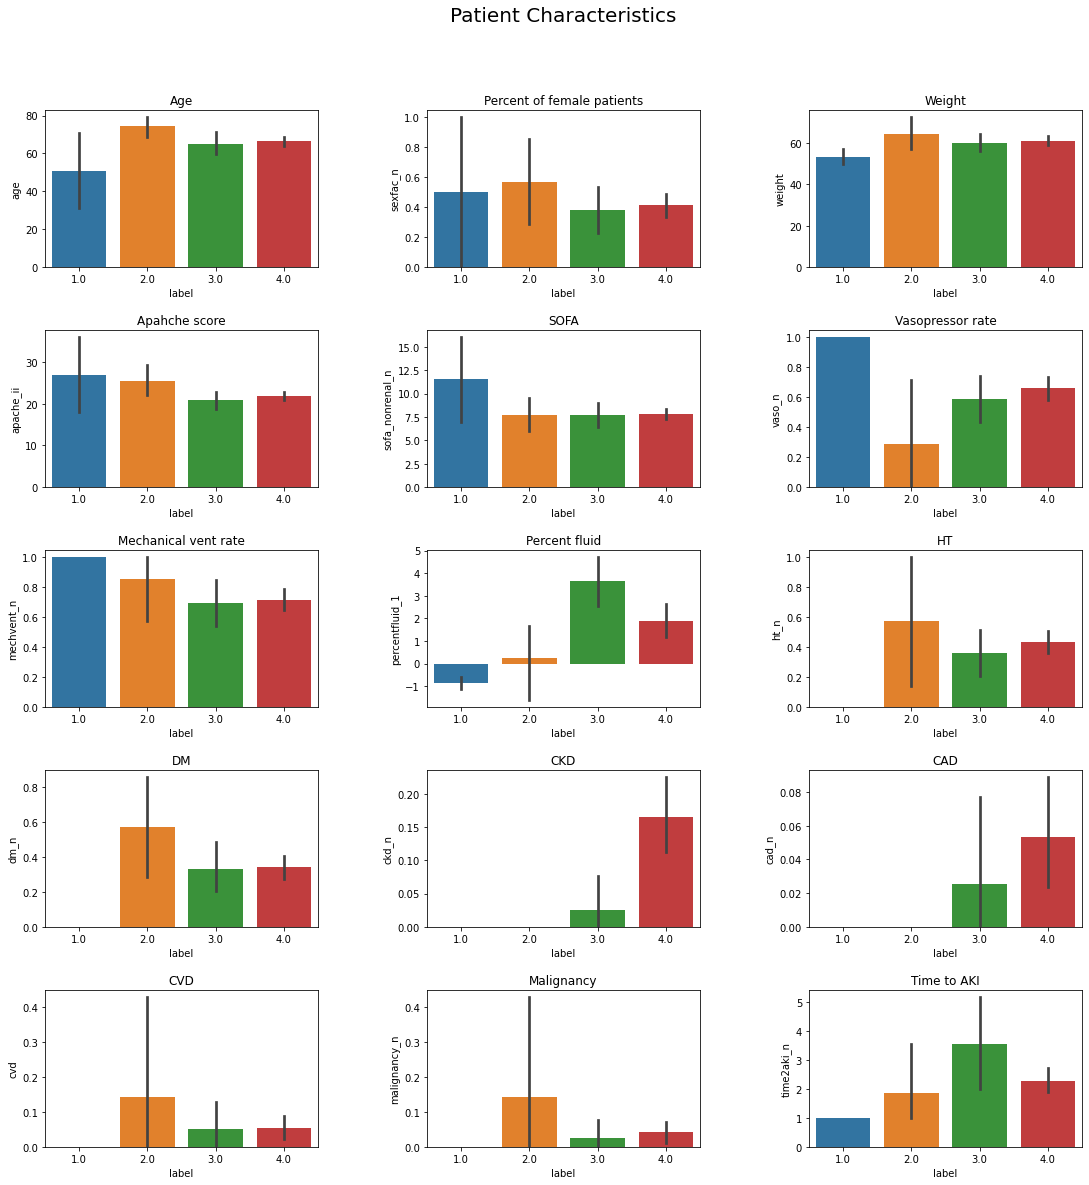

In [493]:
fig, axes = plt.subplots(5,3, figsize=(18,18), sharey=False)
fig.suptitle("Patient Characteristics", fontsize=20)

sns.barplot(ax=axes[0,0], data=df_2, x="label", y="age")
axes[0,0].set_title("Age")
sns.barplot(ax=axes[0,1], data=df_2, x="label", y="sexfac_n")
axes[0,1].set_title("Percent of female patients")
sns.barplot(ax=axes[0,2], data=df_2, x="label", y="weight")
axes[0,2].set_title("Weight")
sns.barplot(ax=axes[1,0], data=df_2, x="label", y="apache_ii")
axes[1,0].set_title("Apahche score")
sns.barplot(ax=axes[1,1], data=df_2, x="label", y="sofa_nonrenal_n")
axes[1,1].set_title("SOFA")
sns.barplot(ax=axes[1,2], data=df_2, x="label", y="vaso_n")
axes[1,2].set_title("Vasopressor rate")
sns.barplot(ax=axes[2,0], data=df_2, x="label", y="mechvent_n")
axes[2,0].set_title("Mechanical vent rate")
sns.barplot(ax=axes[2,1], data=df_2, x="label", y="percentfluid_1")
axes[2,1].set_title("Percent fluid")
sns.barplot(ax=axes[2,2], data=df_2, x="label", y="ht_n")
axes[2,2].set_title("HT")
sns.barplot(ax=axes[3,0], data=df_2, x="label", y="dm_n")
axes[3,0].set_title("DM")
sns.barplot(ax=axes[3,1], data=df_2, x="label", y="ckd_n")
axes[3,1].set_title("CKD")
sns.barplot(ax=axes[3,2], data=df_2, x="label", y="cad_n")
axes[3,2].set_title("CAD")
sns.barplot(ax=axes[4,0], data=df_2, x="label", y="cvd")
axes[4,0].set_title("CVD")
sns.barplot(ax=axes[4,1], data=df_2, x="label", y="malignancy_n")
axes[4,1].set_title("Malignancy")
sns.barplot(ax=axes[4,2], data=df_2, x="label", y="time2aki_n")
axes[4,2].set_title("Time to AKI")



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

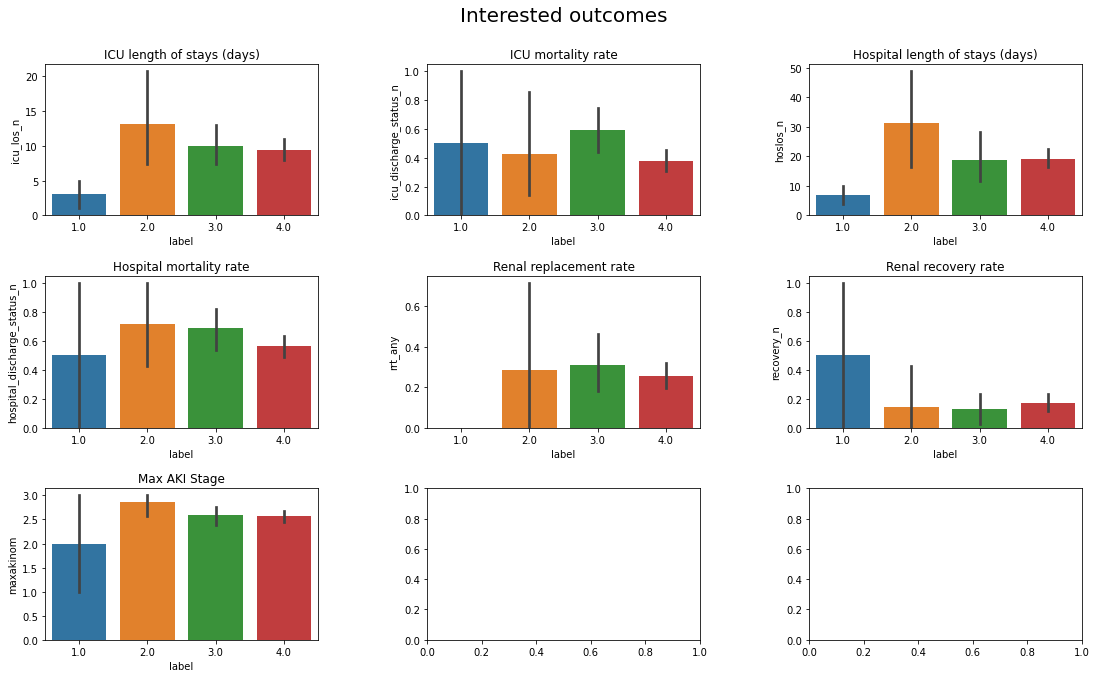

In [494]:
fig, axes = plt.subplots(3,3, figsize=(18,10), sharey=False)
fig.suptitle("Interested outcomes", fontsize=20)

sns.barplot(ax=axes[0,0], data=df_2, x="label", y="icu_los_n")
axes[0,0].set_title("ICU length of stays (days)")
sns.barplot(ax=axes[0,1], data=df_2, x="label", y="icu_discharge_status_n")
axes[0,1].set_title("ICU mortality rate")
sns.barplot(ax=axes[0,2], data=df_2, x="label", y="hoslos_n")
axes[0,2].set_title("Hospital length of stays (days)")
sns.barplot(ax=axes[1,0], data=df_2, x="label", y="hospital_discharge_status_n")
axes[1,0].set_title("Hospital mortality rate")
sns.barplot(ax=axes[1,1], data=df_2, x="label", y="rrt_any")
axes[1,1].set_title("Renal replacement rate")
sns.barplot(ax=axes[1,2], data=df_2, x="label", y="recovery_n")
axes[1,2].set_title("Renal recovery rate")
sns.barplot(ax=axes[2,0], data=df_2, x="label", y="maxakinom")
axes[2,0].set_title("Max AKI Stage")



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Threshold at 230 --> 3 clusters

In [495]:
# label each patient with threshold=230
cluster_scale_3 = fcluster(z_scale, t=230, criterion="distance")

In [496]:
# Check number of each clusters
unique_scale_3, counts_scale_3 = np.unique(cluster_scale_3, return_counts=True)
dict(zip(unique_scale_3, counts_scale_3))

{1: 9, 2: 39, 3: 169}

In [497]:
# Concat label back to creatinine array
aki_5days_scale_label_3 = np.column_stack((aki_5days_complete_scale, cluster_scale_3))

In [498]:
columns_value = ["ROC_1", "ROC_2", "ROC_3", "ROC_4", "ROC_5", "label"]
df_scale_3 = pd.DataFrame(aki_5days_scale_label_3, columns=columns_value)

C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)
C:\Users\Tob\AppData\Local\Continuum\anaconda3\lib\site-packages\tslearn\barycenters\dba.py:736: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  "Stopping optimization.", ConvergenceWarning)


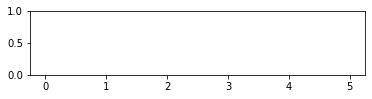

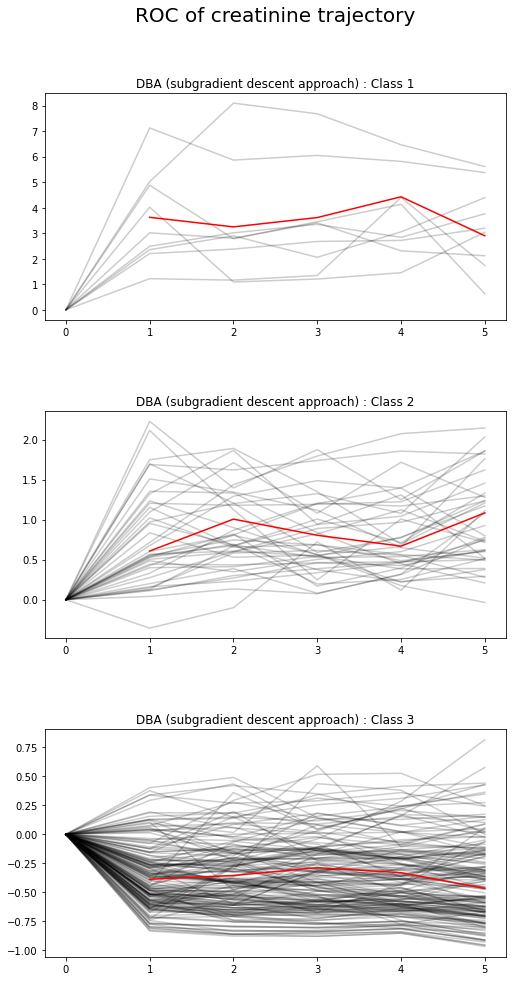

In [499]:
ax3 = plt.subplot(3, 1, 1)
plt.figure(figsize=(8,15))

for i in range(3):
    sam = df_scale_3.loc[df_scale_3["label"] == i+1].transpose()
    sam.drop(index="label", inplace=True)
    q = sam.transpose().to_numpy()
    length_of_sequence = q.shape[1]
    plt.subplot(3, 1, i+1, sharex=ax3)
    plt.title(f"DBA (subgradient descent approach) : Class {i+1}")
    plot_helper(dtw_barycenter_averaging_subgradient(q, max_iter=100, tol=1e-3))

plt.suptitle("ROC of creatinine trajectory", fontsize=20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

In [500]:
df_3 = pd.concat([df_scale_3,aki_select], axis=1)

In [501]:
columns = ["age","sexfac_n","weight","cardiodis","renaldis","infectdis","gastrodis","hematodis","neurodis","rheumdis","oncoldis","surgdis","ht_n","dm_n","ckd_n","cad_n","cvd","malignancy_n","apache_ii","sofa_nonrenal_n","percentfluid_1",
          "vaso_n","mechvent_n","maxakinom","time2aki_n","rrt_any","hoslos_n","hospital_discharge_status_n","icu_los_n","icu_discharge_status_n","recovery_n","baseline","label"]

In [502]:
df_3 = df_3[columns]
df_3 = df_3.apply(convert, axis=1)

In [503]:
group_3 = df_3.groupby("label").mean()
group_3.transpose()

label,1.0,2.0,3.0
age,69.111111,65.153846,66.325444
sexfac_n,0.555556,0.384615,0.414201
weight,62.111111,60.230769,61.236686
cardiodis,0.222222,0.333333,0.396450
renaldis,0.333333,0.102564,0.159763
infectdis,0.666667,0.769231,0.751479
gastrodis,0.222222,0.102564,0.071006
hematodis,0.000000,0.025641,0.035503
neurodis,0.000000,0.051282,0.047337
rheumdis,0.000000,0.000000,0.023669


### Patient baseline characteristics and outcomes by  classes

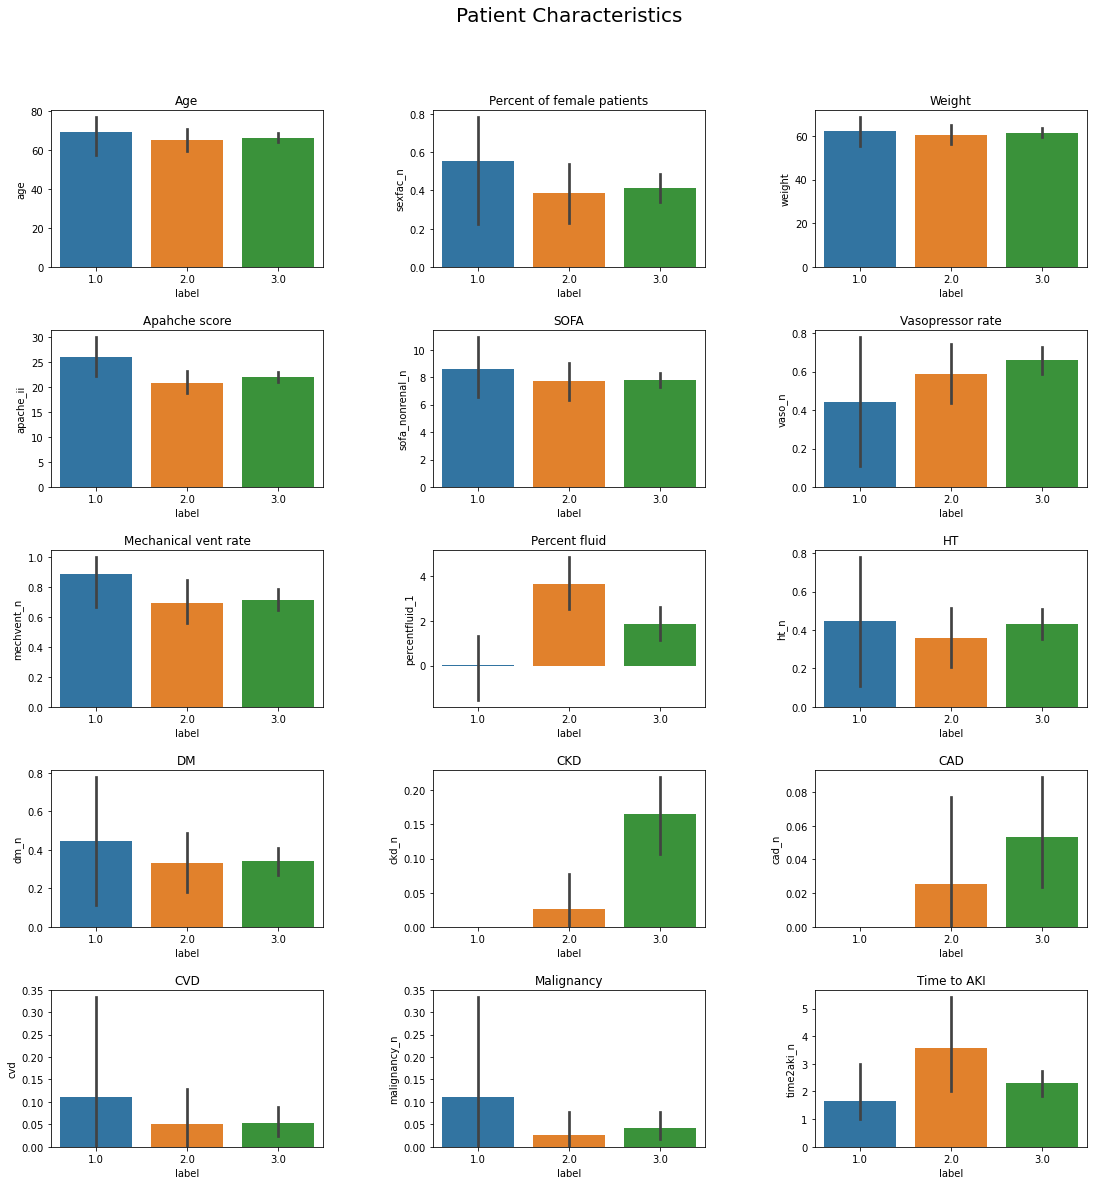

In [504]:
fig, axes = plt.subplots(5,3, figsize=(18,18), sharey=False)
fig.suptitle("Patient Characteristics", fontsize=20)

sns.barplot(ax=axes[0,0], data=df_3, x="label", y="age")
axes[0,0].set_title("Age")
sns.barplot(ax=axes[0,1], data=df_3, x="label", y="sexfac_n")
axes[0,1].set_title("Percent of female patients")
sns.barplot(ax=axes[0,2], data=df_3, x="label", y="weight")
axes[0,2].set_title("Weight")
sns.barplot(ax=axes[1,0], data=df_3, x="label", y="apache_ii")
axes[1,0].set_title("Apahche score")
sns.barplot(ax=axes[1,1], data=df_3, x="label", y="sofa_nonrenal_n")
axes[1,1].set_title("SOFA")
sns.barplot(ax=axes[1,2], data=df_3, x="label", y="vaso_n")
axes[1,2].set_title("Vasopressor rate")
sns.barplot(ax=axes[2,0], data=df_3, x="label", y="mechvent_n")
axes[2,0].set_title("Mechanical vent rate")
sns.barplot(ax=axes[2,1], data=df_3, x="label", y="percentfluid_1")
axes[2,1].set_title("Percent fluid")
sns.barplot(ax=axes[2,2], data=df_3, x="label", y="ht_n")
axes[2,2].set_title("HT")
sns.barplot(ax=axes[3,0], data=df_3, x="label", y="dm_n")
axes[3,0].set_title("DM")
sns.barplot(ax=axes[3,1], data=df_3, x="label", y="ckd_n")
axes[3,1].set_title("CKD")
sns.barplot(ax=axes[3,2], data=df_3, x="label", y="cad_n")
axes[3,2].set_title("CAD")
sns.barplot(ax=axes[4,0], data=df_3, x="label", y="cvd")
axes[4,0].set_title("CVD")
sns.barplot(ax=axes[4,1], data=df_3, x="label", y="malignancy_n")
axes[4,1].set_title("Malignancy")
sns.barplot(ax=axes[4,2], data=df_3, x="label", y="time2aki_n")
axes[4,2].set_title("Time to AKI")



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

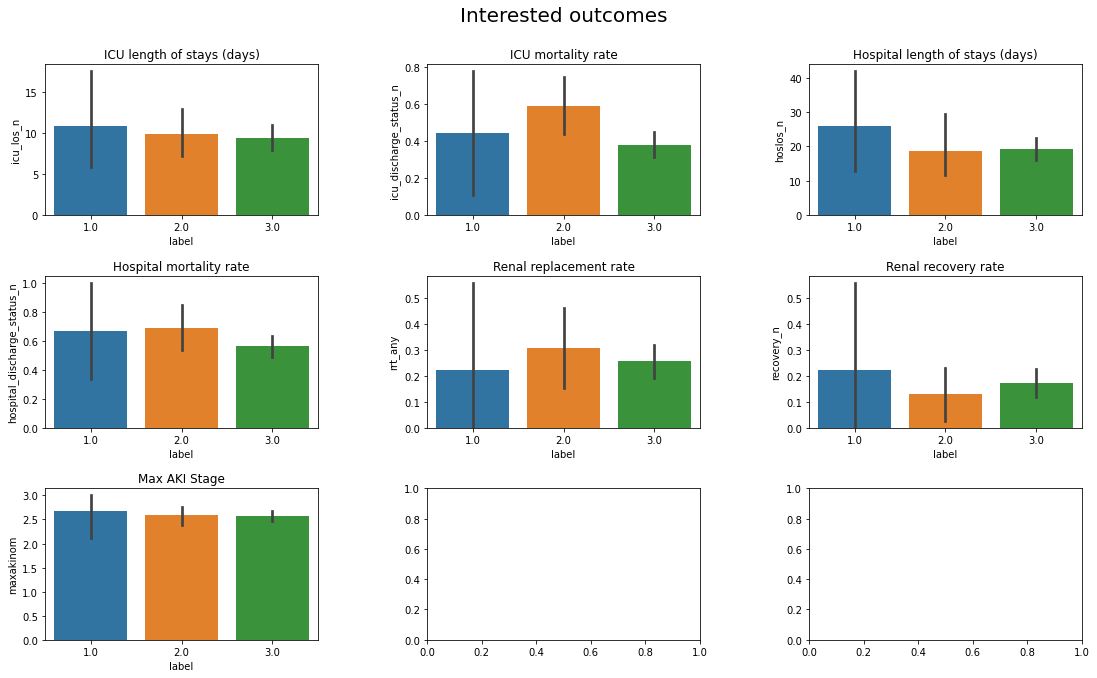

In [505]:
fig, axes = plt.subplots(3,3, figsize=(18,10), sharey=False)
fig.suptitle("Interested outcomes", fontsize=20)

sns.barplot(ax=axes[0,0], data=df_3, x="label", y="icu_los_n")
axes[0,0].set_title("ICU length of stays (days)")
sns.barplot(ax=axes[0,1], data=df_3, x="label", y="icu_discharge_status_n")
axes[0,1].set_title("ICU mortality rate")
sns.barplot(ax=axes[0,2], data=df_3, x="label", y="hoslos_n")
axes[0,2].set_title("Hospital length of stays (days)")
sns.barplot(ax=axes[1,0], data=df_3, x="label", y="hospital_discharge_status_n")
axes[1,0].set_title("Hospital mortality rate")
sns.barplot(ax=axes[1,1], data=df_3, x="label", y="rrt_any")
axes[1,1].set_title("Renal replacement rate")
sns.barplot(ax=axes[1,2], data=df_3, x="label", y="recovery_n")
axes[1,2].set_title("Renal recovery rate")
sns.barplot(ax=axes[2,0], data=df_3, x="label", y="maxakinom")
axes[2,0].set_title("Max AKI Stage")



plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()